In [59]:
import torch
from models.retinal import RetinalModel
from torchinfo import summary
from activation_visualization import single_effective_receptive_field, get_input_output_shape
import numpy as np
from matplotlib import pyplot as plt
from util import normalize
from models.model_builder import load_model, open_experiment
from training import train, num_correct
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision import datasets
from torch import nn
from tqdm import tqdm
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

Using cuda


In [151]:
img_size = (179,143)#(160,120)#(143,107)#
model = RetinalModel(img_size=img_size, num_classes=10, ceil_mode=True)
model.to(device)
transf = [transforms.ToTensor()]
in_channels = model.in_channels
img_size = model.img_size
if in_channels==1:
    transf.append(transforms.Grayscale())
if img_size != 32:
    transf.append(transforms.Resize(img_size, antialias=True))

train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose(transf))
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)
summary(model, (1,3,*img_size))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
RetinalModel                             [1, 10]                   --
├─Sequential: 1-1                        [1, 768]                  --
│    └─Conv2d: 2-1                       [1, 16, 177, 141]         448
│    └─ELU: 2-2                          [1, 16, 177, 141]         --
│    └─AvgPool2d: 2-3                    [1, 16, 59, 47]           --
│    └─Conv2d: 2-4                       [1, 32, 57, 45]           4,640
│    └─ELU: 2-5                          [1, 32, 57, 45]           --
│    └─AvgPool2d: 2-6                    [1, 32, 19, 15]           --
│    └─Conv2d: 2-7                       [1, 32, 19, 15]           1,056
│    └─ELU: 2-8                          [1, 32, 19, 15]           --
│    └─Conv2d: 2-9                       [1, 64, 16, 12]           32,832
│    └─ELU: 2-10                         [1, 64, 16, 12]           --
│    └─MaxPool2d: 2-11                   [1, 64, 4, 3]             --
│   

In [152]:
# for param in model.retina[0].parameters():
#     param.requires_grad = False

In [153]:
(inputs, labels) = next(iter(train_loader))
inputs = inputs.to(device)
labels = labels.to(device)

In [161]:
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005, weight_decay=1e-6)
with torch.autograd.profiler.profile(use_cuda=True, record_shapes=True) as prof:
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Training loop
    model.train()  # Set the model to training mode
    running_loss = 0.0

    epoch_correct = 0
    pbar = tqdm(range(100))
    for i in pbar:
        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        batch_correct =  num_correct(outputs, labels)
        epoch_correct += batch_correct
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pbar.set_postfix({'Loss': loss.item(), 'Acc.:': batch_correct/len(labels)})

STAGE:2023-11-10 14:02:36 19608:19608 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
100%|██████████| 100/100 [00:02<00:00, 41.38it/s]
STAGE:2023-11-10 14:02:39 19608:19608 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-10 14:02:39 19608:19608 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


In [162]:
base_path = "../performance/{}_{}_retinal/".format(*img_size)
if not os.path.exists(base_path):
    os.mkdir(base_path)

In [163]:
prof.export_chrome_trace(base_path + "trace.json")

In [164]:
with open(base_path+"key_averages.csv", "w+t") as f:
    f.write(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cuda_time_total", row_limit=50, max_shapes_column_width=100))

In [165]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="self_cuda_time_total", row_limit=50, max_shapes_column_width=100))

-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------------------  
                                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls                                                                           Input Shapes  
-------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------------------------------------------------  
                          aten::cudnn_convolution         0.24%       5.489ms         0.30%       6.873ms      68.730us     518.826ms        21.88%     518.826ms 

In [159]:
combined_model=trained_model.get_sequential()

NameError: name 'trained_model' is not defined

In [ ]:
combined_model[2]=model.get_sequential()[2]
combined_model[5]=model.get_sequential()[5]
combined_model[10]=model.get_sequential()[10]
combined_model[12]=model.get_sequential()[12]

In [ ]:
combined_model=model

torch.Size([1, 10])
torch.Size([1, 10])
tensor(-5.4803e-14) tensor(6.5849e-14)


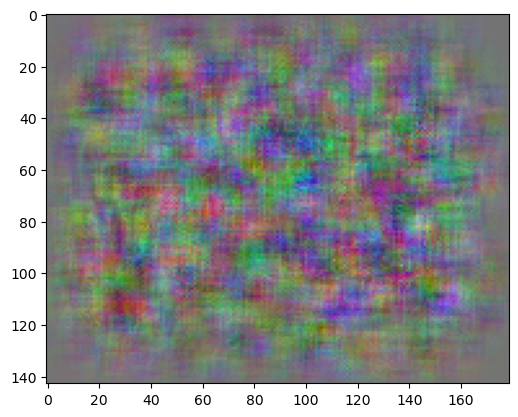

In [ ]:
from activation_visualization import sum_collapse_output, normalizeZeroOne
cur_model = combined_model
cur_img_size = img_size#(16,12)#
out = cur_model(torch.rand((1,3,*cur_img_size)).to(device))
print(out.shape)
out = torch.full_like(sum_collapse_output(out), 0.2)
print(out.shape)
eff_rf = single_effective_receptive_field(cur_model, output_signal=out.to(device), input_size=(3,*cur_img_size), n_batch=1, device=device)
print(eff_rf.min(), eff_rf.max())
plt.imshow(torch.swapdims(normalizeZeroOne(eff_rf), 0,2))
# plt.imshow((eff_rf!=0).numpy()[0])
plt.show()

In [ ]:
cur_model

RetinalModel(
  (retina): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): AvgPool2d(kernel_size=3, stride=3, padding=0)
    (6): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (7): ELU(alpha=1.0)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
    (9): ELU(alpha=1.0)
    (10): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)